# A-analysis-scores

Uses the titanic dataset as an example to introduce classifcation metrics

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Load data

In [2]:
# ## Import data

df_train = pd.read_csv('../data/titanic/train.csv')
df_test = pd.read_csv('../data/titanic/test.csv')

# ## Select columns

id_cols = ['PassengerId', 'Name', 'Cabin', 'Ticket']
y_cols = ['Survived']
X_cols = [col for col in df_train.columns if col not in (id_cols + y_cols) ]

type_list = df_train[X_cols].dtypes
cat_cols = list(type_list[type_list == 'object'].to_dict().keys())
print(50 * '-')
print('Categorical')
print(cat_cols)
print('')

num_cols = [col for col in X_cols if col not in cat_cols]
print(50 * '-')
print('Numerical')
print(num_cols)
print('')

--------------------------------------------------
Categorical
['Sex', 'Embarked']

--------------------------------------------------
Numerical
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



## Pre-process data

In [3]:
# ## Transform objet data
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# ### X encoding
label_encoders = defaultdict(LabelEncoder)
df_train[cat_cols] = df_train[cat_cols].apply(
    lambda x: label_encoders[x.name].fit_transform(x.fillna('NAN')))
df_test[cat_cols] = df_test[cat_cols].apply(
    lambda x: label_encoders[x.name].transform(x.fillna('NAN')))

# ### y label encoding
le_y = defaultdict(LabelEncoder)
df_train[y_cols] = df_train[y_cols].apply(
    lambda x: le_y[x.name].fit_transform(x))

# ### Fill missing values
# #### Get missing values
fill_values = {}
for col in num_cols:
    fill_values[col] = df_train[col].median()

# #### Replace missing values
df_train = df_train.fillna(value=fill_values)
df_test = df_test.fillna(value=fill_values)

# ### Get numpy data
X = df_train[X_cols].values
X_test = df_test[X_cols].values
y = df_train[y_cols].values

# ## Test sklearn
# ### Stratified shuffle split
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
count = 0
for train_index, valid_index in sss.split(X, y):
    # print("TRAIN:", train_index, "VALID:", valid_index)
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

## Train model

In [4]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

nb_estimators = [2, 5, 10, 20, 50, 100, 200, 500, 1000]  #, 2000]
records = []

y_true = np.copy(y_valid)
train_data = Pool(data=X_train.tolist(), label=y_train.ravel().tolist())

VERBOSE = False

for nb_esti in nb_estimators:
    # Define classifier
    clf = CatBoostClassifier(n_estimators=nb_esti, random_seed=42)
    clf.fit(train_data, plot=VERBOSE, logging_level="Silent")
    
    # Compute scores and metric
    y_scores = clf.predict_proba(X_valid)[:,1]
    auc = roc_auc_score(y_true, y_scores)
    
    # Save results in dictionary
    model_record = {'nb_estimators': nb_esti, 'auc': auc, 'clf': clf}
    records.append(model_record)
    
#    if VERBOSE:
#        print(25*"-")
#        print(f"Nb_ estimator: {nb_esti}")
#        print(f"AUC {auc}")
#        print(25*"=")
#        print("")

,auc,clf,nb_estimators
0,0.822069,<catboost.core.CatBoostClassifier object at 0x...,2
1,0.825560,<catboost.core.CatBoostClassifier object at 0x...,5
2,0.837879,<catboost.core.CatBoostClassifier object at 0x...,10
3,0.825362,<catboost.core.CatBoostClassifier object at 0x...,20
4,0.835968,<catboost.core.CatBoostClassifier object at 0x...,50
5,0.830764,<catboost.core.CatBoostClassifier object at 0x...,100
6,0.823781,<catboost.core.CatBoostClassifier object at 0x...,200
7,0.842622,<catboost.core.CatBoostClassifier object at 0x...,500
8,0.846970,<catboost.core.CatBoostClassifier object at 0x...,1000


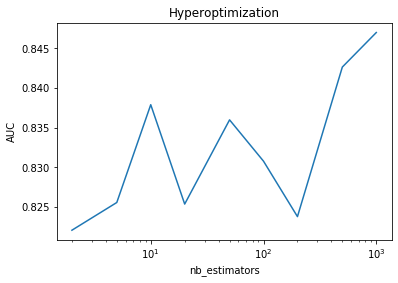

{'auc': 0.846969696969697, 'clf': <catboost.core.CatBoostClassifier object at 0x118bcac90>, 'nb_estimators': 1000}


In [5]:
# ### Compare results
df_records = pd.DataFrame(records)

display(df_records)

plt.figure()
plt.plot(df_records['nb_estimators'], df_records['auc'])
plt.xscale('log')
plt.xlabel('nb_estimators')
plt.ylabel('AUC')
plt.title('Hyperoptimization')
plt.show()

max_auc = df_records['auc'].max()
model_max = df_records[df_records['auc']==max_auc].to_dict('r')[0]
clf_max = model_max['clf'] 
print(model_max)

## Create result dataframe

In [6]:
y_true = np.concatenate([
    y_valid.reshape(y_valid.shape[0]),
    y_train.reshape(y_train.shape[0])
]).astype(int)

y_proba_valid = clf_max.predict_proba(X_valid)
y_proba_train = clf_max.predict_proba(X_train)
y_proba_0 = np.concatenate([y_proba_valid[:,0], y_proba_train[:,0]])
y_proba_1 = np.concatenate([y_proba_valid[:,1], y_proba_train[:,1]])
y_probas = np.concatenate([y_proba_valid, y_proba_train])

data = np.transpose([y_true, y_proba_1])
df_res = pd.DataFrame(data=data, columns=["y_true", "y_proba"])

In [7]:
df_res.head(n=5)

,y_true,y_proba
0,0.0,0.081792
1,0.0,0.111963
2,0.0,0.326604
3,0.0,0.106542
4,1.0,0.991789


## Confusion curve

In [8]:
from sklearn.metrics import confusion_matrix, f1_score

tns, fps, fns, tps = [], [], [] , []
f1_scores = []
thresholds = np.arange(0, 1, 0.01)

for threshold in thresholds:
    y_pred = np.copy(y_proba_1)
    y_pred[np.where(y_pred > threshold)] = 1
    y_pred[np.where(y_pred <= threshold)] = 0
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1 = f1_score(y_true, y_pred)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    f1_scores.append(f1)

### Confusion curves

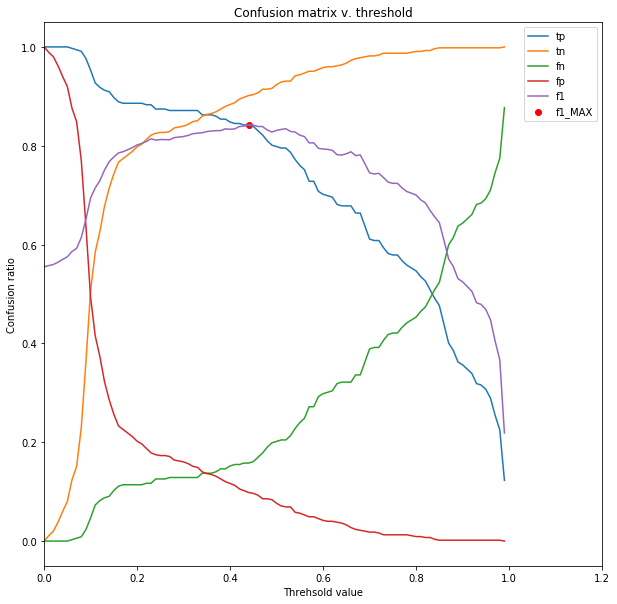

In [9]:
plt.figure(figsize=(10,10))

plt.plot(thresholds, tps / np.max(tps), label="tp")
plt.plot(thresholds, tns / np.max(tns), label="tn")

plt.plot(thresholds, fns / np.max(tps), label="fn")
plt.plot(thresholds, fps / np.max(tns), label="fp")

plt.plot(thresholds, f1_scores, label="f1")
plt.scatter(thresholds[np.argmax(f1_scores)], np.max(f1_scores), label="f1_MAX", color="r")

plt.title("Confusion matrix v. threshold")
plt.xlabel("Threhsold value")
plt.ylabel("Confusion ratio")
plt.xlim(0, 1.2)

plt.legend()
plt.show()

### Positive population v threshold

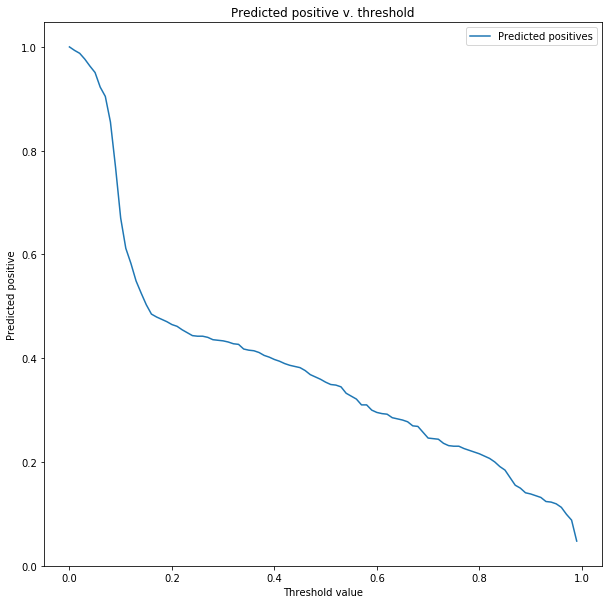

In [10]:
plt.figure(figsize=(10,10))

plt.plot(thresholds, (np.array(tps) + np.array(fps)) / len(y_true), label="Predicted positives")

plt.title("Predicted positive v. threshold")
plt.xlabel("Threshold value")
plt.ylabel("Predicted positive")

plt.legend()
plt.show()

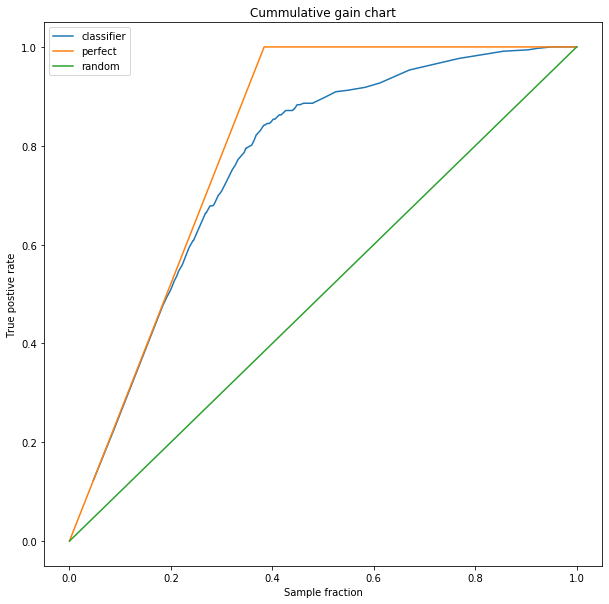

In [11]:
plt.figure(figsize=(10,10))

plt.plot((np.array(tps) + np.array(fps)) / len(y_true), tps / np.max(tps), label="classifier")
plt.plot([0, np.sum(y_true) / len(y_true), 1], [0,1,1], label="perfect")
plt.plot([0, 1], [0, 1], label="random")

plt.title("Cummulative gain chart")
plt.xlabel("Sample fraction")
plt.ylabel("True postive rate")

plt.legend()
plt.show()

### AUC ROC

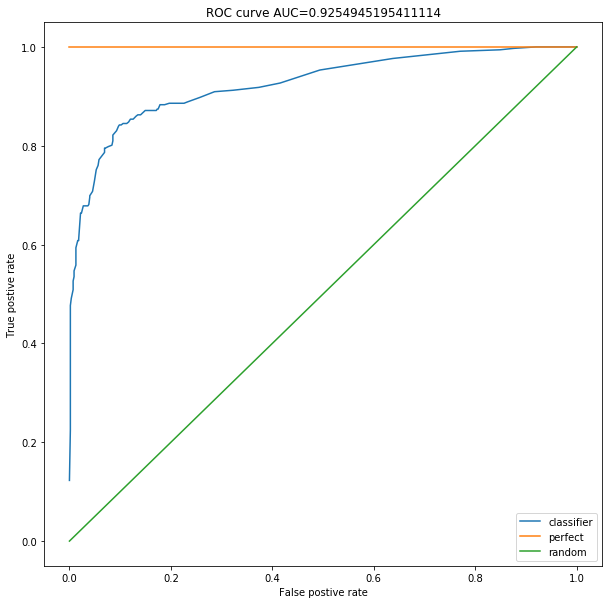

In [12]:
plt.figure(figsize=(10,10))

plt.plot(fps / np.max(tns) , tps / np.max(tps), label="classifier")
plt.plot([0, 1], [1,1], label="perfect")
plt.plot([0, 1], [0, 1], label="random")

plt.title(f"ROC curve AUC={roc_auc_score(y_true, y_proba_1)}")
plt.xlabel("False postive rate")
plt.ylabel("True postive rate")

plt.legend()

plt.show()

---

## End of script